# Minilab 6 - SF Taxi data

In this minilab we will begin to use [linear regression](https://en.wikipedia.org/wiki/Linear_regression) to further look at trends in datasets. We will explore how we can use linear regression to make predictions of taxi fares given the trip distance and trip duration.


The dataset is San Francisco Taxi data from 9/1/2012 to 9/17/2012. The dataset consists of 50,000 taxi trips taken in the Bay Area during that time period. For each trip we are given the departure time, arrival time, passenger fare, departure lat/lon coordinates, arrival lat/lon coordinates, departure taz and arrival taz. 

In [1]:
from datascience import *
import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
sf_taxi = Table.read_table('SF_taxi_data.csv')
sf_taxi

id,departure time,arrival time,fare ($),num,dep lon,dep lat,arr lon,arr lat,deptaz,arrtaz,dist (miles)
0,9/1/12 0:11,9/1/12 0:20,13.2,1,-122.414,37.8027,-122.421,37.7854,38,30,1.98084
1,9/1/12 0:23,9/1/12 0:31,10.65,1,-122.42,37.7861,-122.435,37.7622,30,94,2.40224
2,9/1/12 0:45,9/1/12 0:49,9,1,-122.415,37.7747,-122.408,37.7826,10,11,0.479348
3,9/1/12 0:41,9/1/12 0:54,13.95,2,-122.419,37.8066,-122.415,37.7781,40,10,2.12241
4,9/1/12 1:09,9/1/12 1:13,7.35,1,-122.43,37.7978,-122.418,37.789,45,32,1.03807
5,9/1/12 1:40,9/1/12 1:52,11.75,1,-122.433,37.7841,-122.411,37.787,77,7,0.960851
6,9/1/12 2:49,9/1/12 2:51,5.15,1,-122.409,37.7856,-122.412,37.791,7,29,0.414315
7,9/1/12 3:29,9/1/12 3:47,43.65,1,-122.403,37.7927,-122.386,37.6181,2,239,14.5105
8,9/1/12 0:33,9/1/12 0:57,46.75,1,-122.387,37.6174,-122.407,37.7889,239,5,14.2747
9,9/1/12 4:39,9/1/12 4:43,6.25,1,-122.422,37.7977,-122.418,37.789,34,31,0.685312


## Adding meaningful columns to our data table
The data table is rich, but the inputs are not as useful as they could be. For example we have date/time strings for arrival and departure. We may like to have information on trip duration, rather than a list of start and end times.

### Computing Trip Duration
We can write our own methods to help process the data. For example we can create a method to compute trip duration. First we have to convert the departure time and arrival time into a timestamp, then we can compute the difference. Finally we convert it to minutes. I have written the get_dur() function below.

**Task 1** Use the [.apply](http://data8.org/datascience/_autosummary/datascience.tables.Table.apply.html#datascience.tables.Table.apply) method to create a 'duration (min)' column, a trip 'start hour' column, a trip 'date' column, and a trip 'day of week' column in the sf_taxi table.

In [3]:
def get_hour(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").hour

def get_date(s): 
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date()

def get_weekday(s): # 0 = Monday - 6= Sunday
    return datetime.datetime.strptime(s, "%m/%d/%y %H:%M").date().weekday()

def get_dur(start,finish): 
    start_time = datetime.datetime.strptime(start, "%m/%d/%y %H:%M")
    end_time = datetime.datetime.strptime(finish, "%m/%d/%y %H:%M")
    return (end_time-start_time).seconds/60.

In [4]:
# Answer key
sf_taxi["duration (min)"] = sf_taxi.apply(lambda start, finish: get_dur(start, finish), ["departure time", "arrival time"])
sf_taxi['start hour'] = sf_taxi.apply(get_hour, "departure time")
sf_taxi['date'] = sf_taxi.apply(get_date, "departure time")
sf_taxi['day of week'] = sf_taxi.apply(get_weekday, "departure time")

## Trip fares exploration
SFMTA fare calculation table states that the fare for a trip of x miles will be at least 3.5 + 0.55 * (5x-1). Let us first explore the fare variable by plotting a histogram, and let's create a function to compute this base fare.

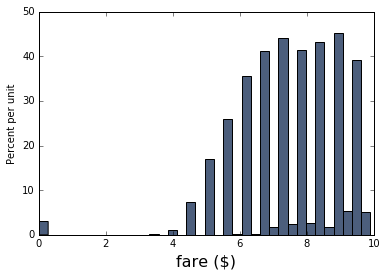

In [5]:
def base_fare(d):
    # 3.5 + 0.55*(5*d - 1), considering only completed 1/5-th miles (hence np.modf()[1])
    return ( 3.5 + 0.55* (np.modf(5*d)[1] - 1) )

# the histogram of trip fares
sf_taxi.select('fare ($)').hist(bins=np.arange(0,10,0.275))

### Most popular taxi trips
Turns out the TAZ that contains SFO is the TAZ that generates the most trips. 

**Task 2** In the cell below, find the most popular "deptaz" from the sf_taxi data - save the taz id as sfo_taz. The data science [group](http://data8.org/datascience/_autosummary/datascience.tables.Table.group.html?highlight=group) funtion might be helpful for this taks.

In [6]:
# Your code here:
# Answer key:
taz_counts = sf_taxi.group("deptaz")
print(taz_counts.where("count", max(taz_counts["count"])))
sfo_taz = taz_counts.where("count", max(taz_counts["count"]))["deptaz"][0]
taz_counts

deptaz | count
239    | 3696


deptaz,count
0,1210
1,1009
2,998
3,190
4,431
5,1267
6,789
7,2072
8,1051
9,758


### Visualize fares data
We are going to explore the dependence between the fare variable for the single-pax trips and the distance travelled. We will see how the actual fare paid relate to the base fare computed with a formula. Finally, we will highlight the trips from/to SFO with a different color. 

* **Task 3** Get trips where the number of passengers == 1 and remove fares <3.5, since base fare=3.5, these are likely to be errors. Save the result as sf_taxi. i.e. save over the previous table.
* ** Task 4** Create a table called sfo where the deptaz or arrtaz is equal to the sfo_taz
* ** Task 5** On the same scatter plot that has all trips, plot fares for trips from SFO in blue.

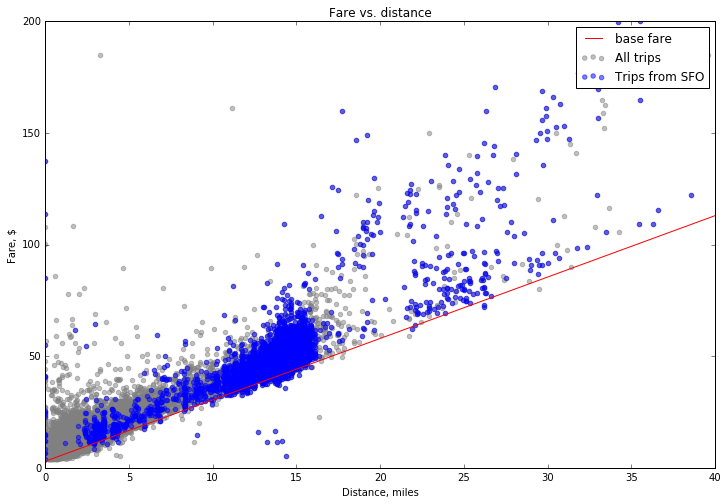

In [21]:
# Task 3 - your code here:

#Answer key:
sf_taxi = sf_taxi.where(sf_taxi["num"]==1)
sf_taxi = sf_taxi.where(sf_taxi["fare ($)"]>3.5)

#Create a scatter plot of the results:
plt.figure(figsize = (12,8))

# plot fares for all trips
x, y =  sf_taxi.column("dist (miles)"), sf_taxi.column("fare ($)")
plt.scatter(x,y,color='grey', alpha =.5, label='All trips')


# Task 4 - your code here:
# Answer key:
sfo = sf_taxi.where((sf_taxi.column("deptaz")==sfo_taz)|
                    (sf_taxi.column("arrtaz")==sfo_taz))


# Task 5 - your code here:
#Answer key:
x, y =  sfo.column("dist (miles)"), sfo.column("fare ($)")
plt.scatter(x,y,color='blue', alpha = .5, label='Trips from SFO')


# plot the lower bound of the fare, i.e. the official formula
plt.plot([0, 40], [base_fare(0), base_fare(40)], 'red', label='Base fare')

plt.title('Fare vs. distance')
plt.xlabel('Distance, miles')
plt.ylabel('Fare, $')
plt.ylim([0,200])
plt.xlim([0,40])
plt.legend()

## Non-SFO trips within 15 miles

Let us narrow it down to the non-SFO trips of 0.1<d<15 miles.
* **Task 6** Create a table called nsfo_taxi that contains all trips where "deptaz" and "arrtaz" are not equal to sfo_taz. Keep only the rows where 0.01<"dist (miles)"<15

In [1]:
# Your code here:
#Answer key
nsfo_taxi = sf_taxi.where((sf_taxi["deptaz"]!=sfo_taz) & (sf_taxi["arrtaz"]!=sfo_taz))
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] < 15)
nsfo_taxi = nsfo_taxi.where(nsfo_taxi["dist (miles)"] > 0.1)

NameError: name 'sf_taxi' is not defined

## Extra fare
In most trips, the actual fare was way higher than the base one. The reason for the extra fare paid by pax is traffic delays (and also drivers taking longer trips than necessary, sometimes due to congestion). Let's see if this extra surcharge is related to the length and duration of the trip. This will help us predict it before a trip started.

In [23]:
# Compute an extra fare paid by passengers
nsfo_taxi["extra"] = nsfo_taxi["fare ($)"] - base_fare(nsfo_taxi["dist (miles)"])


## Linear regression:
The functions below are introduced in data8 'correlation' and 'prediction' topics. See examples in http://data8.org/fa16/lectures/lec29.pdf

In [24]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    "Compute r."
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def predict(x, slope, intercept):
    y = x*slope+intercept
    return y

## Using the linear regression equations
In the cell below: 

**Task 7**
* Find the slope of regression line that correspond to the "extra" cost (y) as a function of "dist (miles)", (x).
* Find the intercept of regression line that relates the "extra" cost (y) as a function of "dist (miles)", (x).
* Predict the 'extra' cost (above the base fare) for a 5 mile trip

In [25]:
# Your code here:

#answer key
extra_dist_slope = slope(nsfo_taxi,'dist (miles)','extra')
extra_dist_intercept = intercept(nsfo_taxi,'dist (miles)','extra')
extra_dist_5mi = predict(5,extra_dist_slope, extra_dist_intercept)
print ('The equation for the best fit regression line is: Extra = %.2f * dist + %.2f'
       %(extra_dist_slope, extra_dist_intercept))
print ('The expected extra cost for a 5 mile trip is $%.2f' %extra_dist_5mi)

The equation for the best fit regression line is: Extra = 0.77 * dist + 2.16
The expected extra cost for a 5 mile trip is $6.01


### Extra Fare vs Trip Length
In the cell below, we construct a scatter plot of the travel distance vs. extra cost (above the base fare). We overlay the best-fit regression line on the plot.

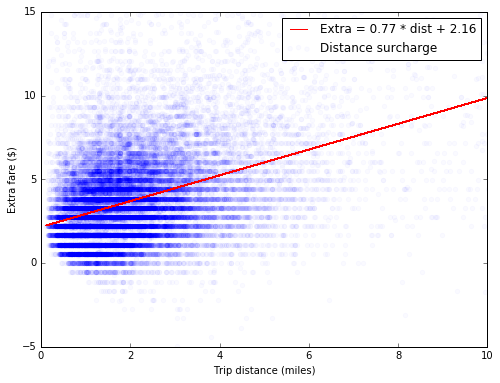

In [36]:
# for convenience, create x, t, extra variables
x, t, extra = nsfo_taxi.column("dist (miles)"), nsfo_taxi.column("duration (min)"), nsfo_taxi.column("extra")

plt.figure(figsize = (8,6))
plt.scatter(x, extra, color='blue', alpha = .02, label='Distance surcharge')

dist_slope = slope(nsfo_taxi,'dist (miles)','extra')
dist_intercept = intercept(nsfo_taxi,'dist (miles)','extra')
plt.plot(x, predict(x,dist_slope,dist_intercept), color='red',
         label='Extra = %.2f * dist + %.2f'%(dist_slope, dist_intercept))

plt.ylim([-5,15])
plt.xlim([0,10])
plt.xlabel("Trip distance (miles)")
plt.ylabel("Extra fare ($)")
plt.legend()

## Extra Fare vs Trip Duration
In the cell below, we construct a scatter plot of the travel time vs. extra cost (above the base fare). We overlay the best-fit regression line on the plot.

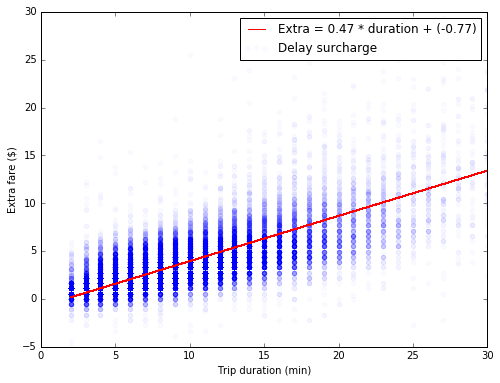

In [35]:
plt.figure(figsize = (8,6))
plt.scatter(t, extra, color='blue', alpha = .02, label='Delay surcharge')

time_slope = slope(nsfo_taxi,'duration (min)','extra')
time_intercept = intercept(nsfo_taxi,'duration (min)','extra')

plt.plot(t, predict(t,time_slope,time_intercept), color='red',
        label='Extra = %.2f * duration + (%.2f)'%(time_slope, time_intercept))
plt.ylim([-5,30])
plt.xlim([0,30])
plt.xlabel("Trip duration (min)")
plt.ylabel("Extra fare ($)")
plt.legend()

## Trip Length or Trip Duration ?
Both length and duration of a trip seem to have an association with extra fares. Longer trips are more expensive. We can characterize this with a correlation coefficient. From looking at the scatter plots which measure seems to be more indicative of the expected extra cost of a trip?

In [14]:
# Your answer here:


We will use the correation function to compare two variables. In the cell below find 
* the correlation between the "dist (miles)" and "extra".
* the correlation between the "duration (min)" and "extra"

Based on these results, does trip length or duration seem to be a better predictor of the extra travel fare?

In [15]:
# Your code here:
#Answer key:
dist_extra_correlation = correlation(nsfo_taxi, 'dist (miles)', 'extra')
time_extra_correlation = correlation(nsfo_taxi, 'duration (min)', 'extra')

print('Trip length and extra fare, r=%.3f' % dist_extra_correlation)
print('Trip duration and extra fare, r=%.3f' % time_extra_correlation)

Trip length and extra fare, r=0.327
Trip duration and extra fare, r=0.738


In [16]:
#Your answer here:
